In [ ]:
!pip -q install openpyxl umap-learn scikit-learn --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 40.8 MB/s eta 0:00:00


## 데이터 전처리

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [ ]:
INPUT_XLSX = "/content/TOTAL_FFDRI.xlsx"
df = pd.read_excel(INPUT_XLSX)

In [ ]:
df.head()

,date,lon,lat,Tmean,RH,EH,WSPD,TP_mm,DEM,DWI,...,피해면적_합계,NDVI,NDVI_used_date,NDVI_source,NDVI_window,NDVI_buffer,DSR_total_MJm^2,lat_r,lon_r,FFDRI
0,2020-04-16,128.719644,35.601783,11.163853,69.870830,69.870830,1.672525,0.510310,192.673490,0.143697,...,0.03,0.527436,2020-04-14,T1_L2_8DAY_NDVI,16,120,25.137471,35.601783,128.719644,33.798017
1,2018-02-26,128.679173,35.613709,3.792093,61.659542,61.659542,1.283533,0.287194,209.267074,0.143354,...,0.05,0.390031,2018-02-26,T1_L2_8DAY_NDVI,16,120,20.077265,35.613709,128.679173,41.293553
2,2015-03-14,128.410871,35.621858,6.223616,46.153654,46.153654,1.129944,1.450675,113.725971,0.410445,...,0.10,0.304935,2015-03-14,T1_L2_8DAY_NDVI,16,120,21.192034,35.621858,128.410871,39.446804
3,2023-04-11,129.299010,35.649642,15.265999,59.527214,59.527214,6.186272,0.480342,195.182195,0.336189,...,0.04,0.225022,2023-04-07,T1_L2_8DAY_NDVI,16,1000,18.200070,35.649642,129.299010,66.475190
4,2020-03-19,128.993318,35.652087,7.102712,52.128863,52.128863,4.328707,22.243611,462.886619,0.310964,...,0.20,0.387215,2020-03-21,T1_L2_8DAY_NDVI,16,120,12.794984,35.652087,128.993318,29.298401


In [ ]:
df_encoded = pd.get_dummies(df, columns=['Cat_forest'], prefix='Cat_forest')

### IQR 방식으로 이상치 제거

In [ ]:
cols = ['Tmean', 'RH', 'EH', 'WSPD', 'TP_mm', 'DEM', 'NDVI', 'DSR_total_MJm^2']

df_out_removed = df_encoded.copy()

mask = pd.Series(True, index=df_out_removed.index)

removed_counts = {}

for col in cols:
    Q1 = df_out_removed[col].quantile(0.25)
    Q3 = df_out_removed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outlier_mask = (df_out_removed[col] < lower) | (df_out_removed[col] > upper)
    removed_counts[col] = outlier_mask.sum()

    mask &= ~outlier_mask


df_out_removed = df_out_removed[mask].reset_index(drop=True)


print(f"제거 전 행 수: {len(df_encoded)} → 제거 후 행 수: {len(df_out_removed)}\n")

print("변수별 제거된 이상치 개수:")
for col, count in removed_counts.items():
    print(f" - {col}: {count}개 제거됨")


제거 전 행 수: 446 → 제거 후 행 수: 347

변수별 제거된 이상치 개수:
 - Tmean: 0개 제거됨
 - RH: 0개 제거됨
 - EH: 0개 제거됨
 - WSPD: 12개 제거됨
 - TP_mm: 74개 제거됨
 - DEM: 18개 제거됨
 - NDVI: 2개 제거됨
 - DSR_total_MJm^2: 0개 제거됨


In [ ]:
case_counts = df_out_removed.groupby(['region', 'Season']).size().reset_index(name='count')

print("4가지 case별 데이터 개수:")
display(case_counts)


4가지 case별 데이터 개수:


,region,Season,count
0,내륙,fall_winter,73
1,내륙,spring,218
2,동해안,fall_winter,23
3,동해안,spring,33


In [ ]:
case_counts = df_out_removed.groupby(['Season']).size().reset_index(name='count')

print("Season 별 데이터 개수:")
display(case_counts)

Season 별 데이터 개수:


,Season,count
0,fall_winter,96
1,spring,251


In [ ]:
case_counts = df_out_removed.groupby(['region']).size().reset_index(name='count')

print("region 별 데이터 개수:")
display(case_counts)

region 별 데이터 개수:


,region,count
0,내륙,291
1,동해안,56


## 클러스터링

## ___________________________________________________________

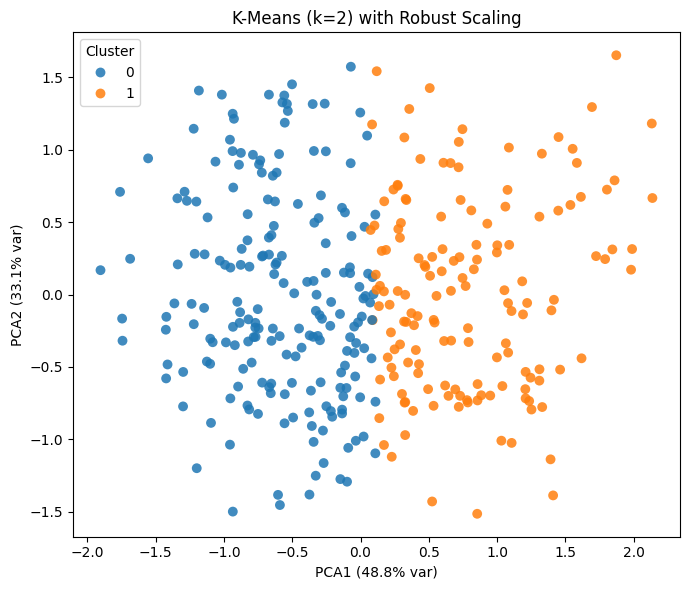

저장 완료: /content/TOTAL_cluster.xlsx


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


RANDOM_STATE = 42
FEATURES = ['NDVI', 'DSR_total_MJm^2','FFDRI']


df = df_out_removed.copy()

X_raw = df[FEATURES].copy()


scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_raw)

X_scaled_df = pd.DataFrame(X_scaled, columns=[f"scaled_{c}" for c in FEATURES], index=df.index)

kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE, n_init=10)
labels = kmeans.fit_predict(X_scaled)
df["cluster_k2"] = labels

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
df["_PCA1"], df["_PCA2"] = X_pca[:, 0], X_pca[:, 1]

plt.figure(figsize=(7, 6))
sns.scatterplot(data=df, x="_PCA1", y="_PCA2", hue="cluster_k2",
                s=50, alpha=0.85, edgecolor="none")
plt.title("K-Means (k=2) with Robust Scaling")
plt.xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PCA2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [ ]:
pca.explained_variance_ratio_

array([0.48772776, 0.33052714])

In [ ]:
pd.crosstab(df["cluster_k2"], [df["Season"]], normalize='index').round(3)

Season,fall_winter,spring
cluster_k2,,
0,0.472,0.528
1,0.020,0.980


In [ ]:
pd.crosstab(df["cluster_k2"], [df["region"]], normalize='index').round(3)

region,내륙,동해안
cluster_k2,,
0,0.812,0.188
1,0.873,0.127


In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(X_scaled, df["cluster_k2"])


0.28787138686675934

In [ ]:
pd.crosstab(df["cluster_k2"], [df["Season"], df["region"]], normalize='index').round(3)


Season     fall_winter        spring       
region              내륙    동해안     내륙    동해안
cluster_k2                                 
0                0.355  0.117  0.457  0.071
1                0.020  0.000  0.853  0.127

## 3개로 분리

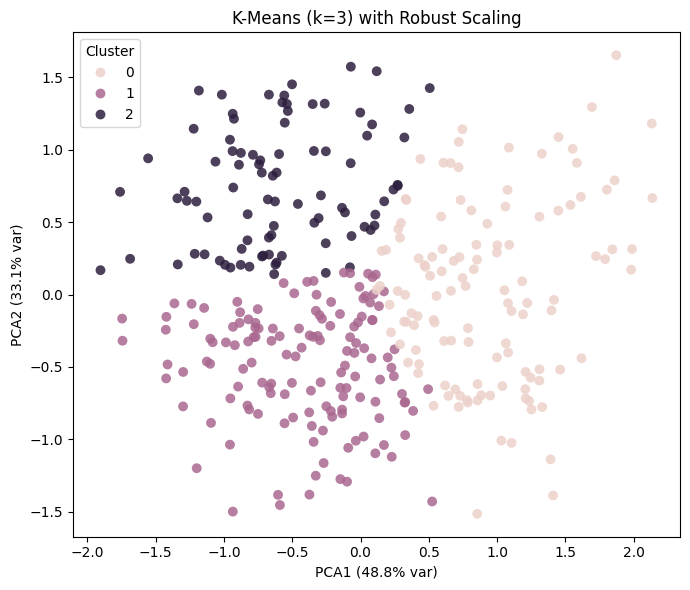

저장 완료: /content/TOTAL_ADD2_clean_scaled.xlsx


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


OUTPUT_CLEAN = "/content/TOTAL_ADD2_clean_scaled.xlsx"
RANDOM_STATE = 42
# FEATURES = ['Tmean', 'RH', 'EH', 'WSPD', 'TP_mm', 'DEM', 'NDVI', 'DSR_total_MJm^2']
FEATURES = ['NDVI', 'DSR_total_MJm^2','FFDRI']


df = df_out_removed.copy()

# 스케일링
X_raw = df[FEATURES].copy()


imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X_raw)

scaler = RobustScaler()  # 극단치에 강함
X_scaled = scaler.fit_transform(X_imp)

X_scaled_df = pd.DataFrame(X_scaled, columns=[f"scaled_{c}" for c in FEATURES], index=df.index)

kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
labels = kmeans.fit_predict(X_scaled)
df["cluster_k3"] = labels

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
df["_PCA1"], df["_PCA2"] = X_pca[:, 0], X_pca[:, 1]

plt.figure(figsize=(7, 6))
sns.scatterplot(data=df, x="_PCA1", y="_PCA2", hue="cluster_k3",
                s=50, alpha=0.85, edgecolor="none")
plt.title("K-Means (k=3) with Robust Scaling")
plt.xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PCA2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


out = pd.concat([df, X_scaled_df], axis=1)
out.to_excel(OUTPUT_CLEAN, index=False)
print(f"저장 완료: {OUTPUT_CLEAN}")


In [ ]:
pd.crosstab(df["cluster_k3"], [df["Season"]], normalize='index').round(3)

Season,fall_winter,spring
cluster_k3,,
0,0.008,0.992
1,0.237,0.763
2,0.705,0.295


In [ ]:
pd.crosstab(df["cluster_k3"], [df["region"]], normalize='index').round(3)

region,내륙,동해안
cluster_k3,,
0,0.883,0.117
1,0.856,0.144
2,0.750,0.250


In [ ]:
pd.crosstab(df["cluster_k3"], [df["region"] + "_" + df["Season"]], normalize='index').round(3)

col_0,내륙_fall_winter,내륙_spring,동해안_fall_winter,동해안_spring
cluster_k3,,,,
0,0.008,0.875,0.000,0.117
1,0.194,0.662,0.043,0.101
2,0.511,0.239,0.193,0.057


## 4개로 클러스터링

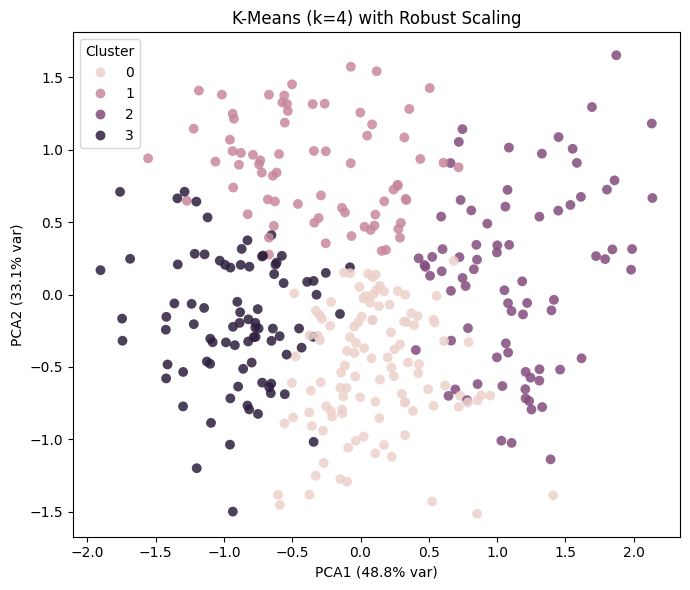

저장 완료: /content/TOTAL_ADD2_clean_scaled.xlsx


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


OUTPUT_CLEAN = "/content/TOTAL_ADD2_clean_scaled.xlsx"
RANDOM_STATE = 42
# FEATURES = ['Tmean', 'RH', 'EH', 'WSPD', 'TP_mm', 'DEM', 'NDVI', 'DSR_total_MJm^2']
FEATURES = ['NDVI', 'DSR_total_MJm^2','FFDRI']

df = df_out_removed.copy()


# 스케일링
# ----------------------------
X_raw = df[FEATURES].copy()


imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X_raw)

scaler = RobustScaler()  # 극단치에 강함
X_scaled = scaler.fit_transform(X_imp)

X_scaled_df = pd.DataFrame(X_scaled, columns=[f"scaled_{c}" for c in FEATURES], index=df.index)


kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=10)
labels = kmeans.fit_predict(X_scaled)
df["cluster_k4"] = labels

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
df["_PCA1"], df["_PCA2"] = X_pca[:, 0], X_pca[:, 1]

plt.figure(figsize=(7, 6))
sns.scatterplot(data=df, x="_PCA1", y="_PCA2", hue="cluster_k4",
                s=50, alpha=0.85, edgecolor="none")
plt.title("K-Means (k=4) with Robust Scaling")
plt.xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PCA2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

out = pd.concat([df, X_scaled_df], axis=1)
out.to_excel(OUTPUT_CLEAN, index=False)
print(f"저장 완료: {OUTPUT_CLEAN}")


In [ ]:
pd.crosstab(df["cluster_k4"], [df["Season"]], normalize='index').round(3)

Season,fall_winter,spring
cluster_k4,,
0,0.018,0.982
1,0.542,0.458
2,0.000,1.000
3,0.647,0.353


In [ ]:
pd.crosstab(df["cluster_k4"], [df["region"]], normalize='index').round(3)

region,내륙,동해안
cluster_k4,,
0,0.874,0.126
1,0.694,0.306
2,0.899,0.101
3,0.859,0.141


In [ ]:
pd.crosstab(df["cluster_k4"], [df["region"] + "_" + df["Season"]], normalize='index').round(3)

col_0,내륙_fall_winter,내륙_spring,동해안_fall_winter,동해안_spring
cluster_k4,,,,
0,0.018,0.856,0.000,0.126
1,0.361,0.333,0.181,0.125
2,0.000,0.899,0.000,0.101
3,0.529,0.329,0.118,0.024
